In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:

data_type = "test"
buffer_folder_list = [f"/media/julius/My Passport1/bufferhdd1/{data_type}",
                                   f"/media/julius/My Passport/bufferhdd2/{data_type}",
                                   f"/mnt/NewHDD/bufferhdd0/{data_type}"]

files_full_path = []
file_labels = []
for folder in buffer_folder_list:
    files = os.listdir(folder)

    del_from_pred = ["_1869_", "_5769_", "_6142_", "_22619_"]
    new_files =  []
    for file in files:
        if not any([delete_id in file for delete_id in del_from_pred]):
            new_files.append(file)

    files_full_path.extend([os.path.join(folder, file) for file in new_files])
    file_labels.extend([int(file.split("_")[0]) for file in new_files])

# TODO: This needs to sort such that first come the healthy or diabetic than the other
calculation_file_list = sorted(zip(files_full_path, file_labels), key=lambda file: (
    int(os.path.basename(file[0]).split("_")[0]),
    int(os.path.basename(file[0]).split("_")[-2]),
    int(os.path.basename(file[0]).split("_")[-1].split(".")[0])))
file_labels = [label for file, label in calculation_file_list]
files_paths = [file for file, label in calculation_file_list]

In [4]:
import random
random.shuffle(files_paths)
len(files_paths[::100])

NameError: name 'files_paths' is not defined

In [18]:
import tensorflow as tf
with tf.device("cpu:0"):
    dataset = tf.data.Dataset.from_tensor_slices(files_paths[::100])

In [19]:
from TFRecordsHandler import parse_tfr_element
import numpy as np
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.map(parse_tfr_element)

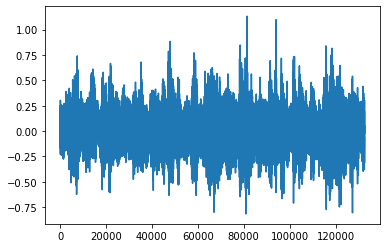

In [25]:

for elem in dataset.take(1):
    plt.plot(elem[0].numpy().flatten())

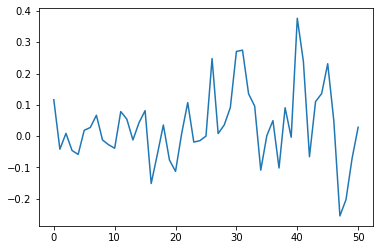

In [35]:
plt.plot(elem[0].numpy()[:, 3, 5, 0])

In [61]:
num = 100
all_ascans = []
color = []
for cscan, label in dataset:
    cscan = cscan.numpy().reshape(-1, 51)
    for i in range(num):
        index = np.random.randint(51*51)
        ascan = cscan[index]
        all_ascans.append(ascan)
        color.append(label)
all_ascans = np.array(all_ascans)

In [5]:
from sklearn.manifold import TSNE

In [68]:
ascan_tsne = TSNE(
    n_components=2, learning_rate="auto", perplexity=18, random_state=0
).fit_transform(all_ascans)

/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'TSNE Embedding of Ascans')

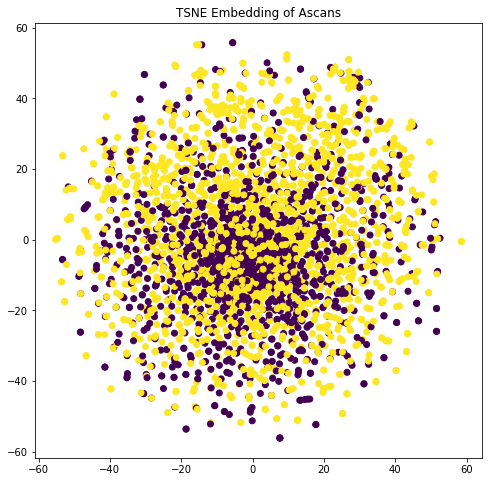

In [69]:
fig, axs = plt.subplots(figsize=(8, 8))
axs.scatter(ascan_tsne[:, 0], ascan_tsne[:, 1], c=color)
axs.set_title("TSNE Embedding of Ascans")

In [6]:
from PreprocessRawData import PreprocessRawData
train_list, file_list = PreprocessRawData.get_test_train_file_lists()

In [119]:
itemsize = 2
b_size = 2048
c_size = 2044
a_size = 1536
ascan_from_file = 100  # 100 = 0.0023 % of A-Scans, 500 MB of Data

all_ascans = []
color = []
names = []
i = 0
for file, label in file_list:
    with open(file, "rb") as f:
        i += 1
        for repetition in range(ascan_from_file):
            ascan_from_index = random.randint(0, int(2 * b_size * c_size / 4))
            index_in_file = 4 * itemsize * ascan_from_index * a_size
            f.seek(index_in_file, os.SEEK_SET)
            read_from_file = np.fromfile(f, dtype=np.dtype('<u2'), count=a_size)
            all_ascans.append(read_from_file)
            names.append(f"Label: {label}; Instance: {i}")
            color.append(label)
        f.seek(itemsize * (2 * b_size * c_size - 1) * a_size, os.SEEK_SET)
        read_from_file = np.fromfile(f, dtype=np.dtype('<u2'), count=a_size)
        all_ascans.append(read_from_file)
        names.append(f"Label: {label}; Instance: {i}")
        color.append(2)
        f.seek(itemsize * (2 * b_size - 1) * a_size, os.SEEK_SET)
        read_from_file = np.fromfile(f, dtype=np.dtype('<u2'), count=a_size)
        all_ascans.append(read_from_file)
        names.append(f"Label: {label}; Instance: {i}")
        color.append(2)
        f.seek(0, os.SEEK_SET)
        read_from_file = np.fromfile(f, dtype=np.dtype('<u2'), count=a_size)
        all_ascans.append(read_from_file)
        names.append(f"Label: {label}; Instance: {i}")
        color.append(2)
all_ascans = np.array(all_ascans)

In [419]:
from numpy.fft import fft, ifft
import skimage.filters as sk_fi
fft_ascan = ifft(all_ascans[:, 400::], axis=1)
num_a = int(fft_ascan.shape[1]/2)

#fft_ascan_pp = np.concatenate((np.abs(fft_ascan[:, 1:num_a]), np.angle(fft_ascan[:, 1:])), axis=1)
fft_ascan_pp = np.abs(fft_ascan[:, 1:num_a])
fft_ascan_pp = sk_fi.median(fft_ascan_pp, np.ones((1, 3)))
from sklearn.decomposition import PCA
pca = PCA(n_components=204)
reduced = pca.fit_transform(fft_ascan_pp)

In [426]:
from skimage.morphology import disk
from skimage.filters.rank import maximum
fft_ascan_pp = maximum(fft_ascan_pp, disk(3))

/tmp/ipykernel_266917/503916285.py:3: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  fft_ascan_pp = maximum(fft_ascan_pp, disk(3))


ValueError: Images of type float must be between -1 and 1.

In [424]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
#X, y = load_iris(return_X_y=True)
#X.shape

X_new = SelectKBest(mutual_info_classif, k=51).fit_transform(reduced, color)
X_new.shape

(2781, 51)

/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


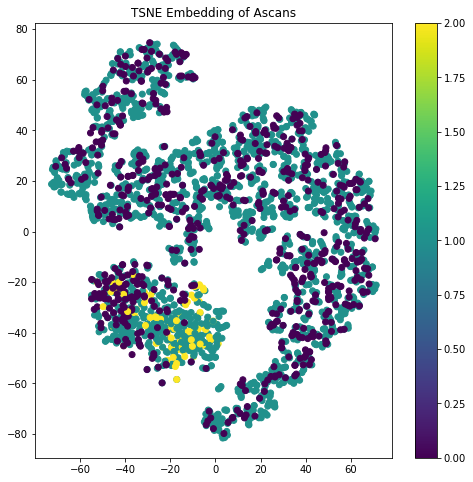

In [425]:
ascan_tsne = TSNE(
    n_components=2, learning_rate="auto", perplexity=10, random_state=0
).fit_transform(X_new
                )
fig, axs = plt.subplots(figsize=(8, 8))
im = axs.scatter(ascan_tsne[::-1, 0], ascan_tsne[::-1, 1], c=color[::-1])
axs.set_title("TSNE Embedding of Ascans")
plt.colorbar(im)

In [394]:
import sklearn.cluster as sk_cl
clustering = sk_cl.AgglomerativeClustering(n_clusters=50, affinity="cosine", linkage="average").fit(reduced[:, ::])

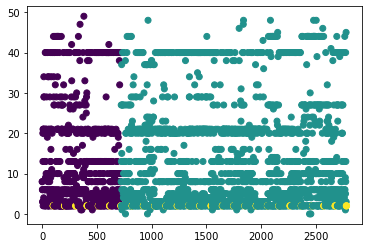

In [395]:
plt.scatter(list(range(2781)), clustering.labels_, c=color)

/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


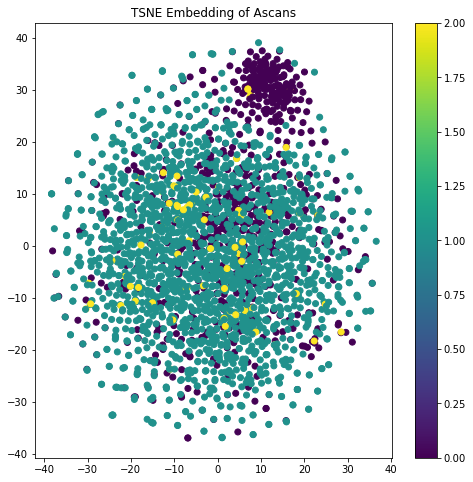

In [135]:
ascan_tsne = TSNE(
    n_components=2, learning_rate="auto", perplexity=15, random_state=0
).fit_transform(all_ascans[:, 400::4])
fig, axs = plt.subplots(figsize=(8, 8))
im = axs.scatter(ascan_tsne[:, 0], ascan_tsne[:, 1], c=color)
axs.set_title("TSNE Embedding of Ascans")
plt.colorbar(im)

/home/julius/miniconda3/envs/tf-test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


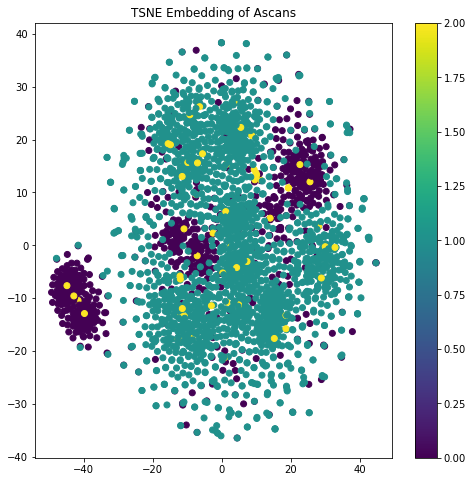

In [72]:
ascan_tsne = TSNE(
    n_components=2, learning_rate="auto", perplexity=15, random_state=0
).fit_transform(all_ascans[:, 400:1400])
fig, axs = plt.subplots(figsize=(8, 8))
im = axs.scatter(ascan_tsne[:, 0], ascan_tsne[:, 1], c=color)
axs.set_title("TSNE Embedding of Ascans")
plt.colorbar(im)

In [15]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [109]:
p = figure()
p.circle(ascan_tsne[:, 0], ascan_tsne[:, 1], fill_color=color, alpha=0.6)

GlyphRenderer(id='1116', ...)

In [46]:
names2 = np.array([int(name[-1]) for name in names])

In [44]:
names2.shape

(2754,)

In [37]:
ascan_tsne[:, 1].shape

(2754,)

In [60]:
from bokeh.transform import linear_cmap

source = ColumnDataSource(data=dict(
    x=ascan_tsne[:, 0],
    y=ascan_tsne[:, 1],
    color=color,
    desc=names2,
))

TOOLTIPS = [
    ("index", "$index"),
    ("desc", "$desc"),
    #("class", "$color"),
]
p = figure(width=800, height=800, tooltips=TOOLTIPS,
           title="Mouse over the dots")

color2= [c * 120 for c in color]

def fuck_you_bokeh(dumb):
    if dumb == 0:
        return "#FF0000"
    if dumb == 1:
        return "#00FF00"
    if dumb == 2:
        return "#0000FF"
fill_color = [fuck_you_bokeh(color) for color in color]


p.circle(ascan_tsne[:, 0], ascan_tsne[:, 1], size=10, fill_color=fill_color, fill_alpha=0.6, line_color="#000000")
show(p)

df
